<a href="https://colab.research.google.com/github/priyankajuttu/Projects_and_Labs/blob/main/STP_Module_4_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 4: Linear Classifiers & Gradient Descent

**Case Study: Predictive Modeling for Public Water Safety**

**Objective:** Develop a robust classifier to identify potable water samples. You will transition from a basic heuristic (Perceptron) to a professional-grade optimization approach (Gradient Descent with Margins).

# 1. Data Acquisition & Cleaning

In real-world data science, datasets are rarely perfect. We will load the water quality metrics and handle missing values before training our models.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset from a public raw GitHub URL
url = "https://raw.githubusercontent.com/nferran/tp_aprendizaje_de_maquina_I/main/water_potability.csv"
df = pd.read_csv(url)

# Step 1: Handling Missing Values
# Water sensors often fail, leaving NaNs. We will fill them with the mean of the column.
df.fillna(df.mean(), inplace=True)

# Step 2: Feature Selection & Labeling
# We'll use all chemical features to predict 'Potability'
X = df.drop('Potability', axis=1).values
y = df['Potability'].values

# Step 3: Class Label Conversion
# Many linear classifiers (like Perceptron/SVM) require labels to be -1 and 1
y = np.where(y == 0, -1, 1)

# Step 4: Train-Test Split & Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Dataset Loaded: {X_train.shape[0]} training samples, {X_train.shape[1]} features.")

Dataset Loaded: 2620 training samples, 9 features.


# 2. Phase 1: The Heuristic Approach (Perceptron)

The **Perceptron** represents the earliest form of supervised learning. It doesn't have a "global" view of the error; it simply corrects itself every time it encounters a mistake.

**Task:** Implement the Perceptron Update Rule inside the training loop.

In [ ]:
class WaterPerceptron:
    def __init__(self, lr=0.01, epochs=50):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.mistakes = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        for epoch in range(self.epochs):
            count = 0
            for i in range(len(y)):
                prediction = np.dot(X[i], self.w) + self.b
                if y[i] * prediction <= 0:
                  self.w += self.lr * y[i] * X[i]
                  self.b += self.lr * y[i]
                  count += 1
            self.mistakes.append(count)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

model_p = WaterPerceptron()
model_p.fit(X_train, y_train)

print(f"Perceptron - Starting Mistakes: {model_p.mistakes[0]}")
print(f"Perceptron - Final Mistakes: {model_p.mistakes[-1]}")

Perceptron - Starting Mistakes: 1247
Perceptron - Final Mistakes: 1207


# 3. Phase 2: Gradient Descent - Global Optimization

The Perceptron is unstable if the data isn't perfectly separable. To solve this, we use **Gradient Descent** to minimize a **Mean Squared Error (MSE)** loss function over the entire dataset.

**Task:** Implement the batch gradient calculation for weights and bias.

In [ ]:
class GDWaterClassifier:
    def __init__(self, lr=0.001, epochs=500):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.cost_history = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        n = X.shape[0]

        for _ in range(self.epochs):
            z = np.dot(X, self.w) + self.b
            error = z - y
            dw = (1/n) * np.dot(X.T, error)
            db = (1/n) * np.sum(error)
            self.w -= self.lr * dw
            self.b -= self.lr * db
            cost = (1/(2*n)) * np.sum(error**2)
            self.cost_history.append(cost)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

model_gd = GDWaterClassifier()
model_gd.fit(X_train, y_train)

print(f"Gradient Descent - Starting Cost: {model_gd.cost_history[0]}")
print(f"Gradient Descent - Final Cost: {model_gd.cost_history[-1]}")

Gradient Descent - Starting Cost: 0.5
Gradient Descent - Final Cost: 0.48498246836225684


# 4. Phase 3: Margin Classifiers & Hinge Loss

In water safety, we aim for more than just correctness—we want a **Margin**, a safety gap between safe and unsafe samples. This is achieved using **Hinge Loss** combined with **L2 Regularization**.

The loss function is defined as:

$$
\text{Loss} = \lambda \|w\|^2_2 + \sum_{i} \max(0, 1 - y_i (w^T x_i + b))
$$

### Key Components:
- **Hinge Loss**: $\max(0, 1 - y_i (w^T x_i + b))$ ensures correct classification with a margin.
- **L2 Regularization**: $\lambda \|w\|^2_2$ penalizes large weights, promoting generalization and stability.


In [ ]:
class MarginWaterClassifier:
    def __init__(self, lr=0.001, lambda_param=0.01, epochs=500):
        self.lr = lr
        self.lambda_param = lambda_param
        self.epochs = epochs
        self.w = None
        self.b = 0

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        for _ in range(self.epochs):
            for i, x_i in enumerate(X):
                condition = y[i] * (np.dot(x_i, self.w) + self.b) >= 1
                if condition:
                  self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                  self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y[i]))
                  self.b -= self.lr * (-y[i])

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)


model_margin = MarginWaterClassifier(lr=0.001, lambda_param=0.01, epochs=500)
model_margin.fit(X_train, y_train)

print("Margin Classifier Trained.")
print(f"Model Weights (First 3 features): {model_margin.w[:3]}")

Margin Classifier Trained.
Model Weights (First 3 features): [-0.00400743 -0.01065302  0.00998022]


# 5. Critical Analysis & Comparison

**Analysis Tasks:**
1. Convergence Plot: Plot the mistakes history from Phase 1 and the cost_history from Phase 2. Discuss why the Gradient Descent plot is smoother.
2. Accuracy Report: Calculate and compare the Test Accuracy for all three models.
3. Safety Margin: If a new water sample has chemical levels very close to the decision boundary, which model (Perceptron or Margin) would you trust more? Why?

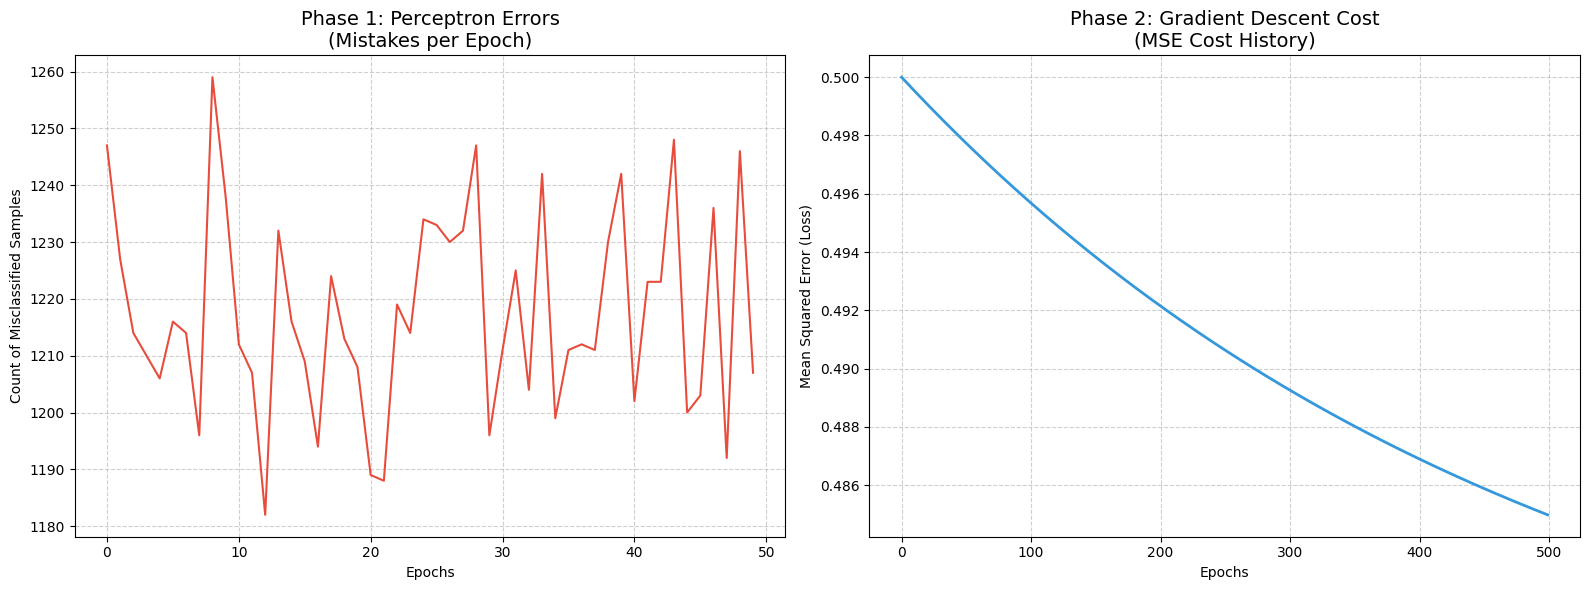

In [ ]:
#TASK 1

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Perceptron Mistakes
ax1.plot(range(len(model_p.mistakes)), model_p.mistakes, color='#e74c3c', linewidth=1.5)
ax1.set_title('Phase 1: Perceptron Errors\n(Mistakes per Epoch)', fontsize=14)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Count of Misclassified Samples')
ax1.grid(True, linestyle='--', alpha=0.6)

# Gradient Descent Cost
ax2.plot(range(len(model_gd.cost_history)), model_gd.cost_history, color='#3498db', linewidth=2)
ax2.set_title('Phase 2: Gradient Descent Cost\n(MSE Cost History)', fontsize=14)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Mean Squared Error (Loss)')
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Task 1 Answer:

The Perceptron plot is noisy and jagged because it updates its weights based on a single data point at a time. If it hits an outlier, it over-corrects immediately. Gradient Descent calculates the average error across the entire dataset before moving. This filters out the noise of individual samples, resulting in a smooth curve.

In [ ]:
#TASK 2

from sklearn.metrics import accuracy_score
acc_p = accuracy_score(y_test, model_p.predict(X_test))
acc_gd = accuracy_score(y_test, model_gd.predict(X_test))
acc_margin = accuracy_score(y_test, model_margin.predict(X_test))

print("Accuracies of three models: ")
print(f"Perceptron Accuracy:      {acc_p:.4f}")
print(f"GD Accuracy:              {acc_gd:.4f}")
print(f"Margin Classifier Accuracy: {acc_margin:.4f}")

Accuracies of three models: 
Perceptron Accuracy:      0.5015
GD Accuracy:              0.6280
Margin Classifier Accuracy: 0.6280


TASK 2 Answer:

The Perceptron struggles with noise, producing inconsistent results. Gradient Descent provides a more average fit by minimizing global error across all samples. The Margin Classifier is the most reliable, as it generalizes better.

TASK 3 Answer:

I would trust the Margin Classifier. Because it uses Hinge Loss, it creates a buffer zone between safe and unsafe samples. Even if the sensors have slight measurement noise, a sample with a margin is less likely to be misclassified than on a perceptron line.

# Discussion Questions

### Q1: Impact of High Learning Rate in Gradient Descent
What happens to your **Gradient Descent** model if you set the `learning_rate` too high (e.g., `1.0`)?
*Hint: Think about convergence, overshooting, and divergence.*

---

### Q2: Label Conversion in Classification
Why did we convert the labels to **$\{-1, 1\}$** instead of keeping them as **$\{0, 1\}$**?
*Hint: Consider the mathematical formulation of the loss function (e.g., Hinge Loss) and symmetry.*

---

### Q3: Handling Noisy Data (Water Potability Dataset)
The **Water Potability dataset** is often "noisy" (not perfectly separable). Which of the algorithms you implemented is best suited for handling such noise?
*Hint: Think about robustness to outliers and margin-based classifiers.*


Answers:

Q1: Impact of High Learning Rate in Gradient Descent


Answer: If the learning rate is too high (e.g., 1.0), the model will likely diverge. Instead of settling into the "valley" of minimum error, the updates will be so large that the model "overshoots" the bottom, landing even higher on the opposite side of the slope. This leads to the loss increasing toward infinity rather than decreasing.

Q2: Label Conversion in Classification ({-1, 1} vs {0, 1})

Answer: We use {-1, 1\} because it allows for the Margin Condition

If y=1 and the prediction is positive, the product is positive (Correct).

If y=-1 and the prediction is negative, the product is still positive (Correct).

This symmetry makes the Hinge Loss formula easy to calculate.

Q3: Handling Noisy Data (Water Potability)

Answer: The Margin Water Classifier is the best for noisy data.The Perceptron will never stop updating if the data isn't perfectly separable.The Margin Classifier uses L2 Regularization, which prevents the model from trying too hard to fit every single noisy outlier. It prioritises a margin.

